In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from textwrap import wrap
import re
from statsmodels.stats.proportion import proportion_confint

# Load the data
# table = pd.read_csv('Redcap CardiacArrestPrognos_DATA_LABELS_2024-11-04_1628.csv')
table = pd.read_csv('CardiacArrestPrognos_DATA_LABELS_2025-01-12_2011 .corrected.csv')

def has_coverage(df, period):
    """
    Return a boolean series indicating which patients have EEG coverage in the given period.
    Coverage is defined as having at least one EEG pattern (for that period) marked as "Checked".
    """
    # Build a list of columns corresponding to the time period.
    # For example, for period '24 hours', look for columns containing "the 24 hours EEG"
    pattern = f"the {period} EEG"
    cols = [col for col in df.columns if pattern in col]
    
    if not cols:
        # If no matching columns are found, return all False.
        return pd.Series([False] * len(df), index=df.index)
    
    # For each patient, check if any of these columns has the value "Checked"
    return df[cols].eq("Checked").any(axis=1)

def summary_table(df, choices_list, ci_level=95):
    hours = [
        '24 hours',
        '48 hours',
        '72 hours',
        'rest of'
    ]
    
    rows = []

    for choice in choices_list:
        for period in hours:
            col_label = f'All EEG patterns in   the {period} EEG (choice={choice})'
            
            # Use the updated coverage calculation:
            coverage_mask = has_coverage(df, period)
            coverage_df = df[coverage_mask]
            total_patients_with_coverage = coverage_df.shape[0]

            # Calculate Died and Survived based on patients with EEG coverage only
            Died = len(coverage_df[coverage_df['CPC at Discharge'] == 'dead'])
            Survived = len(coverage_df[coverage_df['CPC at Discharge'] == 'not dead'])

            died_percentage = (Died / total_patients_with_coverage) * 100 if total_patients_with_coverage > 0 else np.nan
            survived_percentage = (Survived / total_patients_with_coverage) * 100 if total_patients_with_coverage > 0 else np.nan

            if col_label in df.columns:
                tp_patients = coverage_df[(coverage_df[col_label] == 'Checked') & (coverage_df['CPC at Discharge'] == 'dead')]
                TP = len(tp_patients)
                
                fp_patients = coverage_df[(coverage_df[col_label] == 'Checked') & (coverage_df['CPC at Discharge'] == 'not dead')]
                FP = len(fp_patients)
                
                fn_patients = coverage_df[(coverage_df['CPC at Discharge'] == 'dead') & (coverage_df[col_label] != 'Checked')]
                FN = len(fn_patients)
                
                tn_patients = coverage_df[(coverage_df['CPC at Discharge'] == 'not dead') & (coverage_df[col_label] != 'Checked')]
                TN = len(tn_patients)

                # Check that TP + FP + FN + TN equals total patients with coverage
                confusion_sum = TP + FP + FN + TN
                if confusion_sum != total_patients_with_coverage:
                    raise ValueError(
                        f"Error: TP+FP+FN+TN = {confusion_sum}, but Total = {total_patients_with_coverage} for "
                        f"Choice={choice}, Time Period={period}"
                    )
                
                # Compute metrics
                TPR = (TP / (TP + FN)) if (TP + FN) > 0 else np.nan
                FPR = (FP / (FP + TN)) if (FP + TN) > 0 else np.nan
                PPV = (TP / (TP + FP)) if (TP + FP) > 0 else np.nan
                NPV = (TN / (TN + FN)) if (TN + FN) > 0 else np.nan

                # Compute exact confidence intervals using Clopper-Pearson
                TPR_ci_lower, TPR_ci_upper = proportion_confint(count=TP, nobs=TP + FN, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (TP + FN) > 0 else (np.nan, np.nan)
                FPR_ci_lower, FPR_ci_upper = proportion_confint(count=FP, nobs=FP + TN, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (FP + TN) > 0 else (np.nan, np.nan)
                PPV_ci_lower, PPV_ci_upper = proportion_confint(count=TP, nobs=TP + FP, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (TP + FP) > 0 else (np.nan, np.nan)
                NPV_ci_lower, NPV_ci_upper = proportion_confint(count=TN, nobs=TN + FN, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (TN + FN) > 0 else (np.nan, np.nan)

                rows.append({
                    'Choice': choice,
                    'Time Period': period,
                    'Total': total_patients_with_coverage,
                    'Died': Died,
                    'Survived': Survived,
                    'Died_Percentage': died_percentage,
                    'Survived_Percentage': survived_percentage,
                    'TP': TP,
                    'FP': FP,
                    'FN': FN,
                    'TN': TN,
                    'TP+FP+FN+TN': confusion_sum,
                    'TPR': TPR,
                    'TPR_CI_lower': TPR_ci_lower,
                    'TPR_CI_upper': TPR_ci_upper,
                    'FPR': FPR,
                    'FPR_CI_lower': FPR_ci_lower,
                    'FPR_CI_upper': FPR_ci_upper,
                    'PPV': PPV,
                    'PPV_CI_lower': PPV_ci_lower,
                    'PPV_CI_upper': PPV_ci_upper,
                    'NPV': NPV,
                    'NPV_CI_lower': NPV_ci_lower,
                    'NPV_CI_upper': NPV_ci_upper
                })
            else:
                # If the column doesn't exist, no patients had the pattern checked during this period
                TP = 0
                FP = 0
                FN = Died
                TN = Survived
                confusion_sum = TP + FP + FN + TN
                if confusion_sum != total_patients_with_coverage:
                    raise ValueError(
                        f"Error: TP+FP+FN+TN = {confusion_sum}, but Total = {total_patients_with_coverage} for "
                        f"Choice={choice}, Time Period={period} (No pattern column)"
                    )
                
                TPR = (TP / (TP + FN)) if (TP + FN) > 0 else np.nan
                FPR = (FP / (FP + TN)) if (FP + TN) > 0 else np.nan
                PPV = (TP / (TP + FP)) if (TP + FP) > 0 else np.nan
                NPV = (TN / (TN + FN)) if (TN + FN) > 0 else np.nan

                TPR_ci_lower, TPR_ci_upper = proportion_confint(count=TP, nobs=TP + FN, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (TP + FN) > 0 else (np.nan, np.nan)
                FPR_ci_lower, FPR_ci_upper = proportion_confint(count=FP, nobs=FP + TN, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (FP + TN) > 0 else (np.nan, np.nan)
                PPV_ci_lower, PPV_ci_upper = proportion_confint(count=TP, nobs=TP + FP, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (TP + FP) > 0 else (np.nan, np.nan)
                NPV_ci_lower, NPV_ci_upper = proportion_confint(count=TN, nobs=TN + FN, 
                                                                 alpha=(100 - ci_level)/100, method='beta') if (TN + FN) > 0 else (np.nan, np.nan)

                rows.append({
                    'Choice': choice,
                    'Time Period': period,
                    'Total': total_patients_with_coverage,
                    'Died': Died,
                    'Survived': Survived,
                    'Died_Percentage': died_percentage,
                    'Survived_Percentage': survived_percentage,
                    'TP': TP,
                    'FP': FP,
                    'FN': FN,
                    'TN': TN,
                    'TP+FP+FN+TN': confusion_sum,
                    'TPR': TPR,
                    'TPR_CI_lower': TPR_ci_lower,
                    'TPR_CI_upper': TPR_ci_upper,
                    'FPR': FPR,
                    'FPR_CI_lower': FPR_ci_lower,
                    'FPR_CI_upper': FPR_ci_upper,
                    'PPV': PPV,
                    'PPV_CI_lower': PPV_ci_lower,
                    'PPV_CI_upper': PPV_ci_upper,
                    'NPV': NPV,
                    'NPV_CI_lower': NPV_ci_lower,
                    'NPV_CI_upper': NPV_ci_upper
                })

    summary_df = pd.DataFrame(rows)
    return summary_df

choices_list = [
    'best_background_alpha', 'best_background_theta','best_background_delta',    
    'Discontinuous EEG', 'EEG reactivity', 'Background anytime attenuated 10-20 uV',
    'Background anytime suppressed < 10 uV', 'Burst suppression', 'Burst suppression with identical bursts',
    'Burst suppression with highly epileptiform bursts', 'Seizure', 'Status epilepticus',
    'Myoclonic Status epilepticus (time-locked myoclonus and epileptiform discharges)',
    'GPD', 'LPD', 'LRDA', 'GRDA', 'SED', 'SIRPDs', 'BIRDs', 'Diffuse voltage suppression', 'BIPD', 'Absent EEG reactivity'
]

# Generate the summary table with exact confidence intervals
df_summary = summary_table(table, choices_list, ci_level=95)

# Format floats to two decimals (ignoring NaNs)
df_summary = df_summary.applymap(lambda x: f'{x:.2f}' if (isinstance(x, float) and not np.isnan(x)) else x)

# Calculate overall death percentages per Choice (for potential downstream use)
death_percentages = df_summary.groupby('Choice').apply(
    lambda x: (
        pd.to_numeric(x['Died'], errors='coerce').sum() /
        (pd.to_numeric(x['Died'], errors='coerce').sum() + pd.to_numeric(x['Survived'], errors='coerce').sum())
    ) * 100 if (pd.to_numeric(x['Died'], errors='coerce').sum() + pd.to_numeric(x['Survived'], errors='coerce').sum()) > 0 else np.nan
).sort_values()

choices = death_percentages.index

def sanitize_filename(filename):
    return re.sub(r'[<>:"/\\|?*]', '', filename)

# Save the summary table to CSV
df_summary.to_csv('summary_table_with_exact_CI_2025_02_18.csv', index=False)


/var/folders/lg/qf0_x9r91qjg9ndqydrbphzw0000gq/T/ipykernel_94623/2549288814.py:189: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_summary = df_summary.applymap(lambda x: f'{x:.2f}' if (isinstance(x, float) and not np.isnan(x)) else x)
/var/folders/lg/qf0_x9r91qjg9ndqydrbphzw0000gq/T/ipykernel_94623/2549288814.py:192: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  death_percentages = df_summary.groupby('Choice').apply(


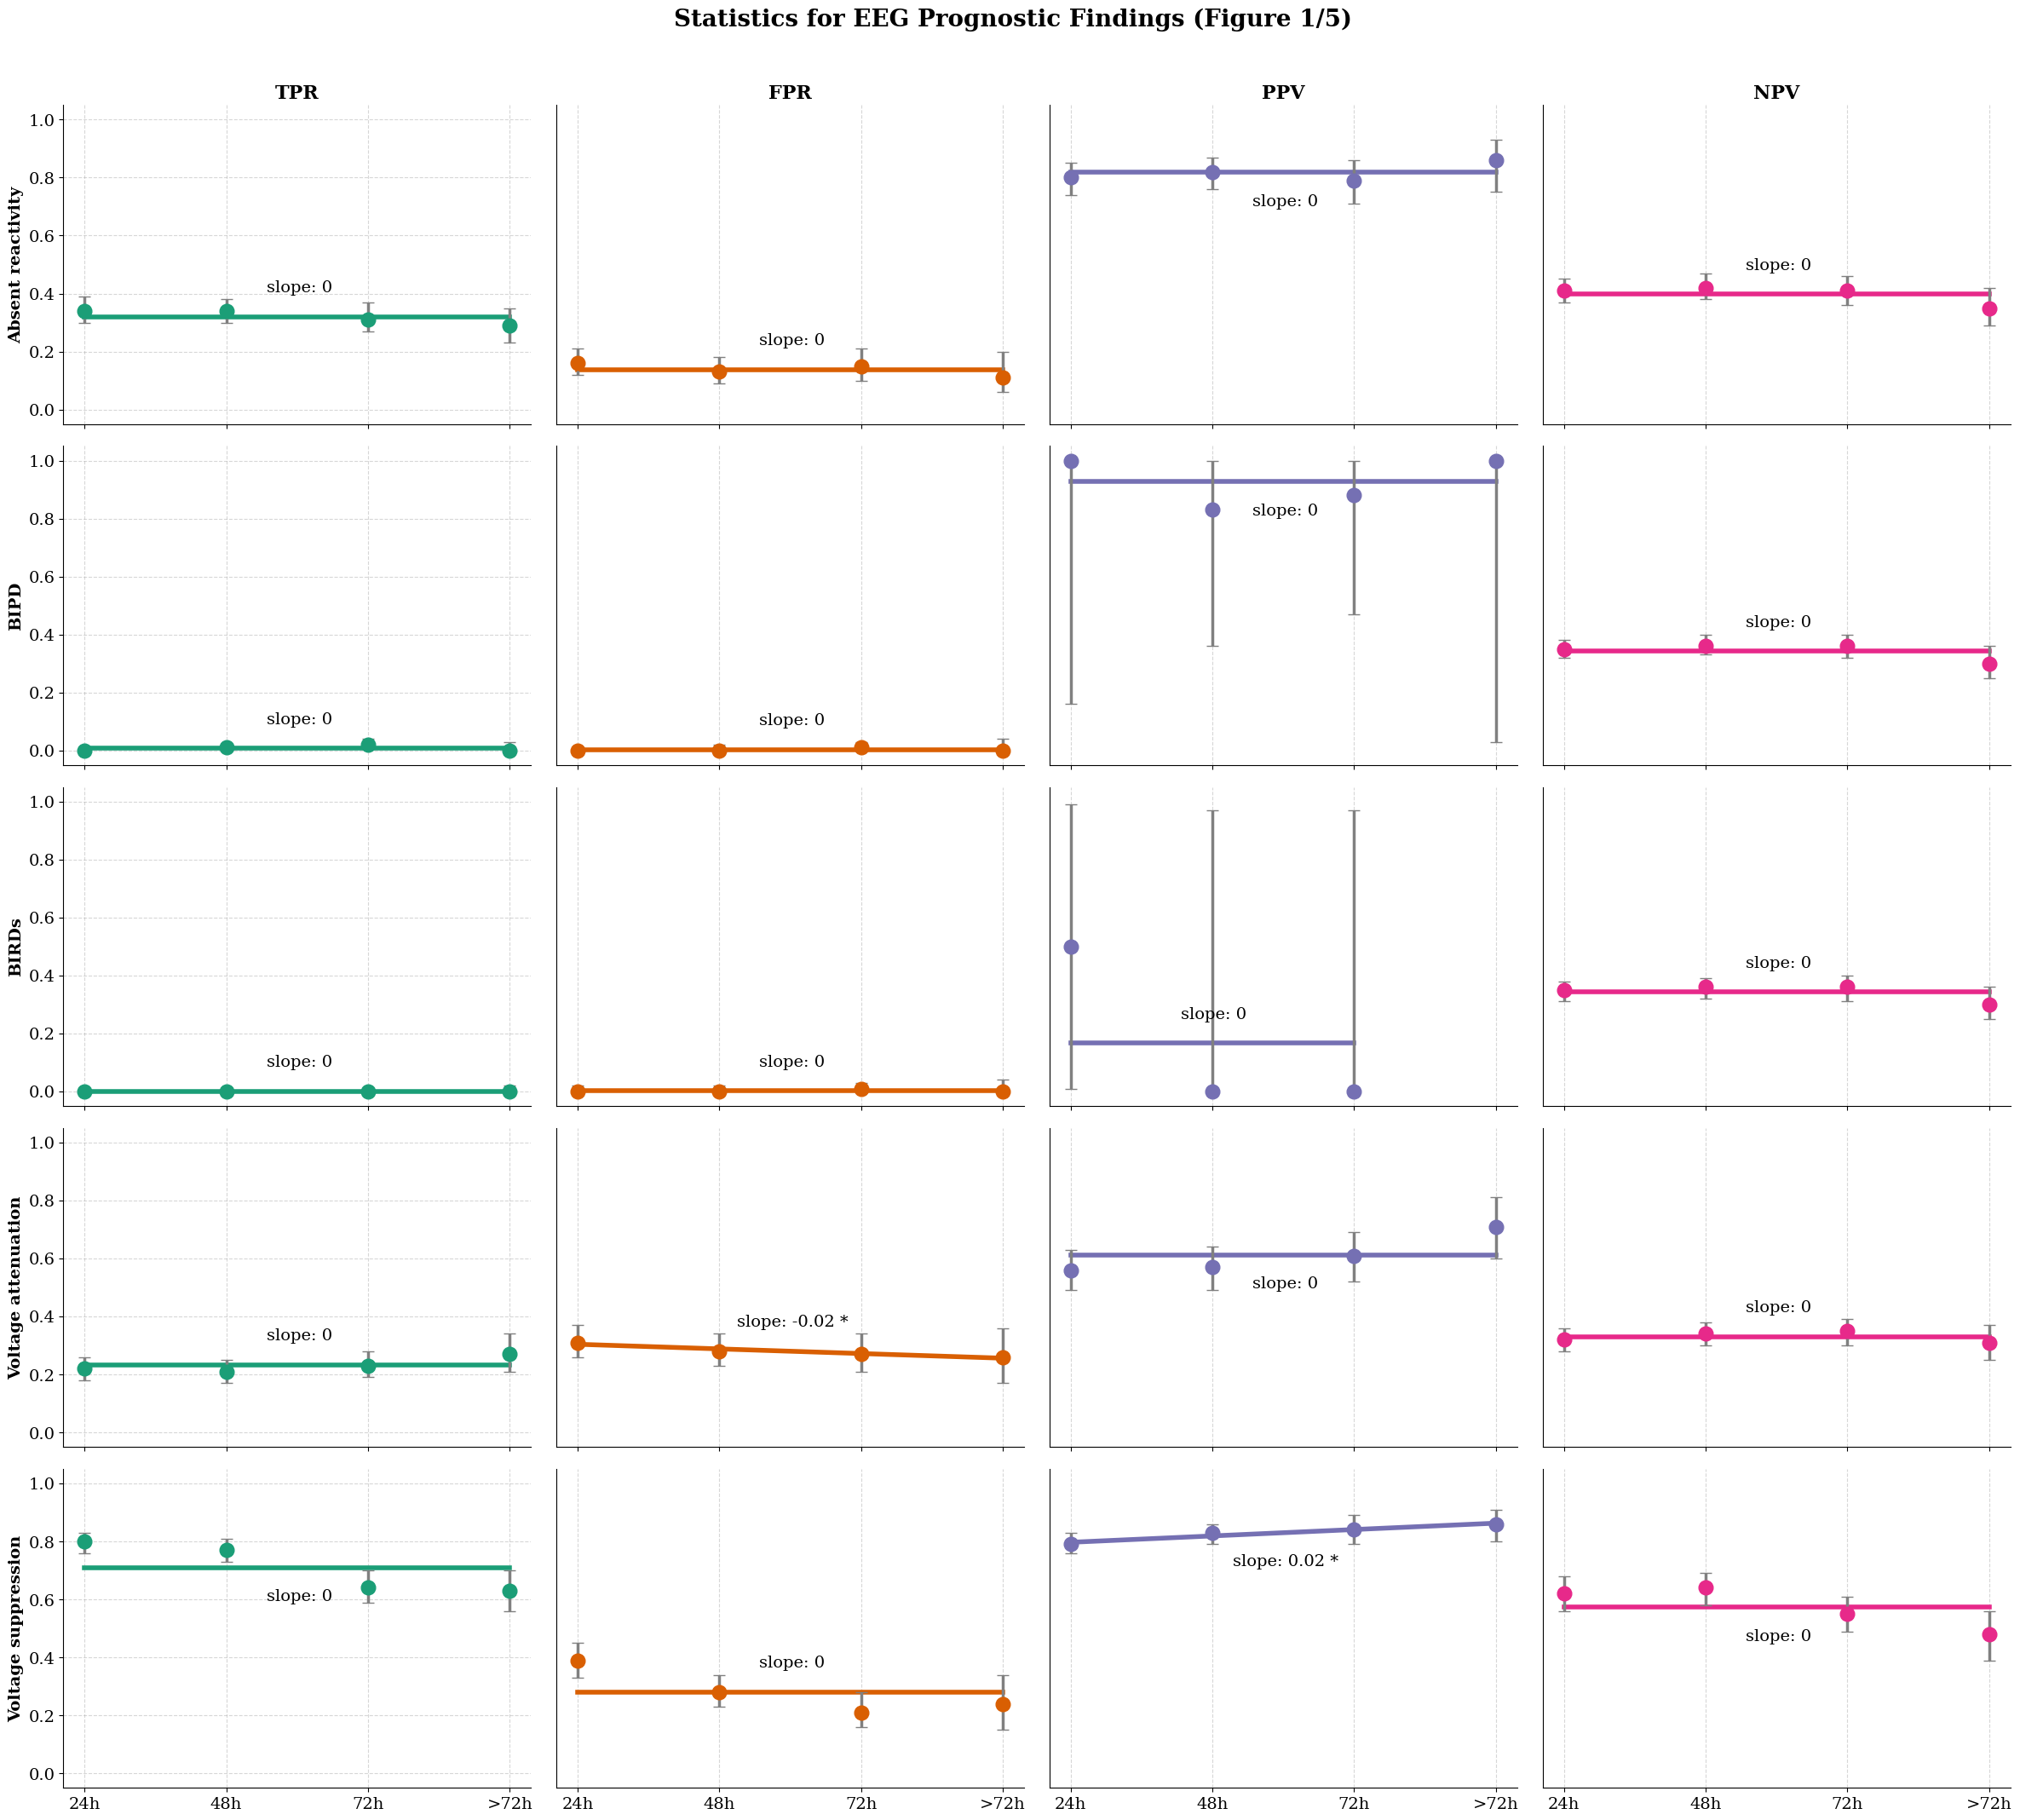

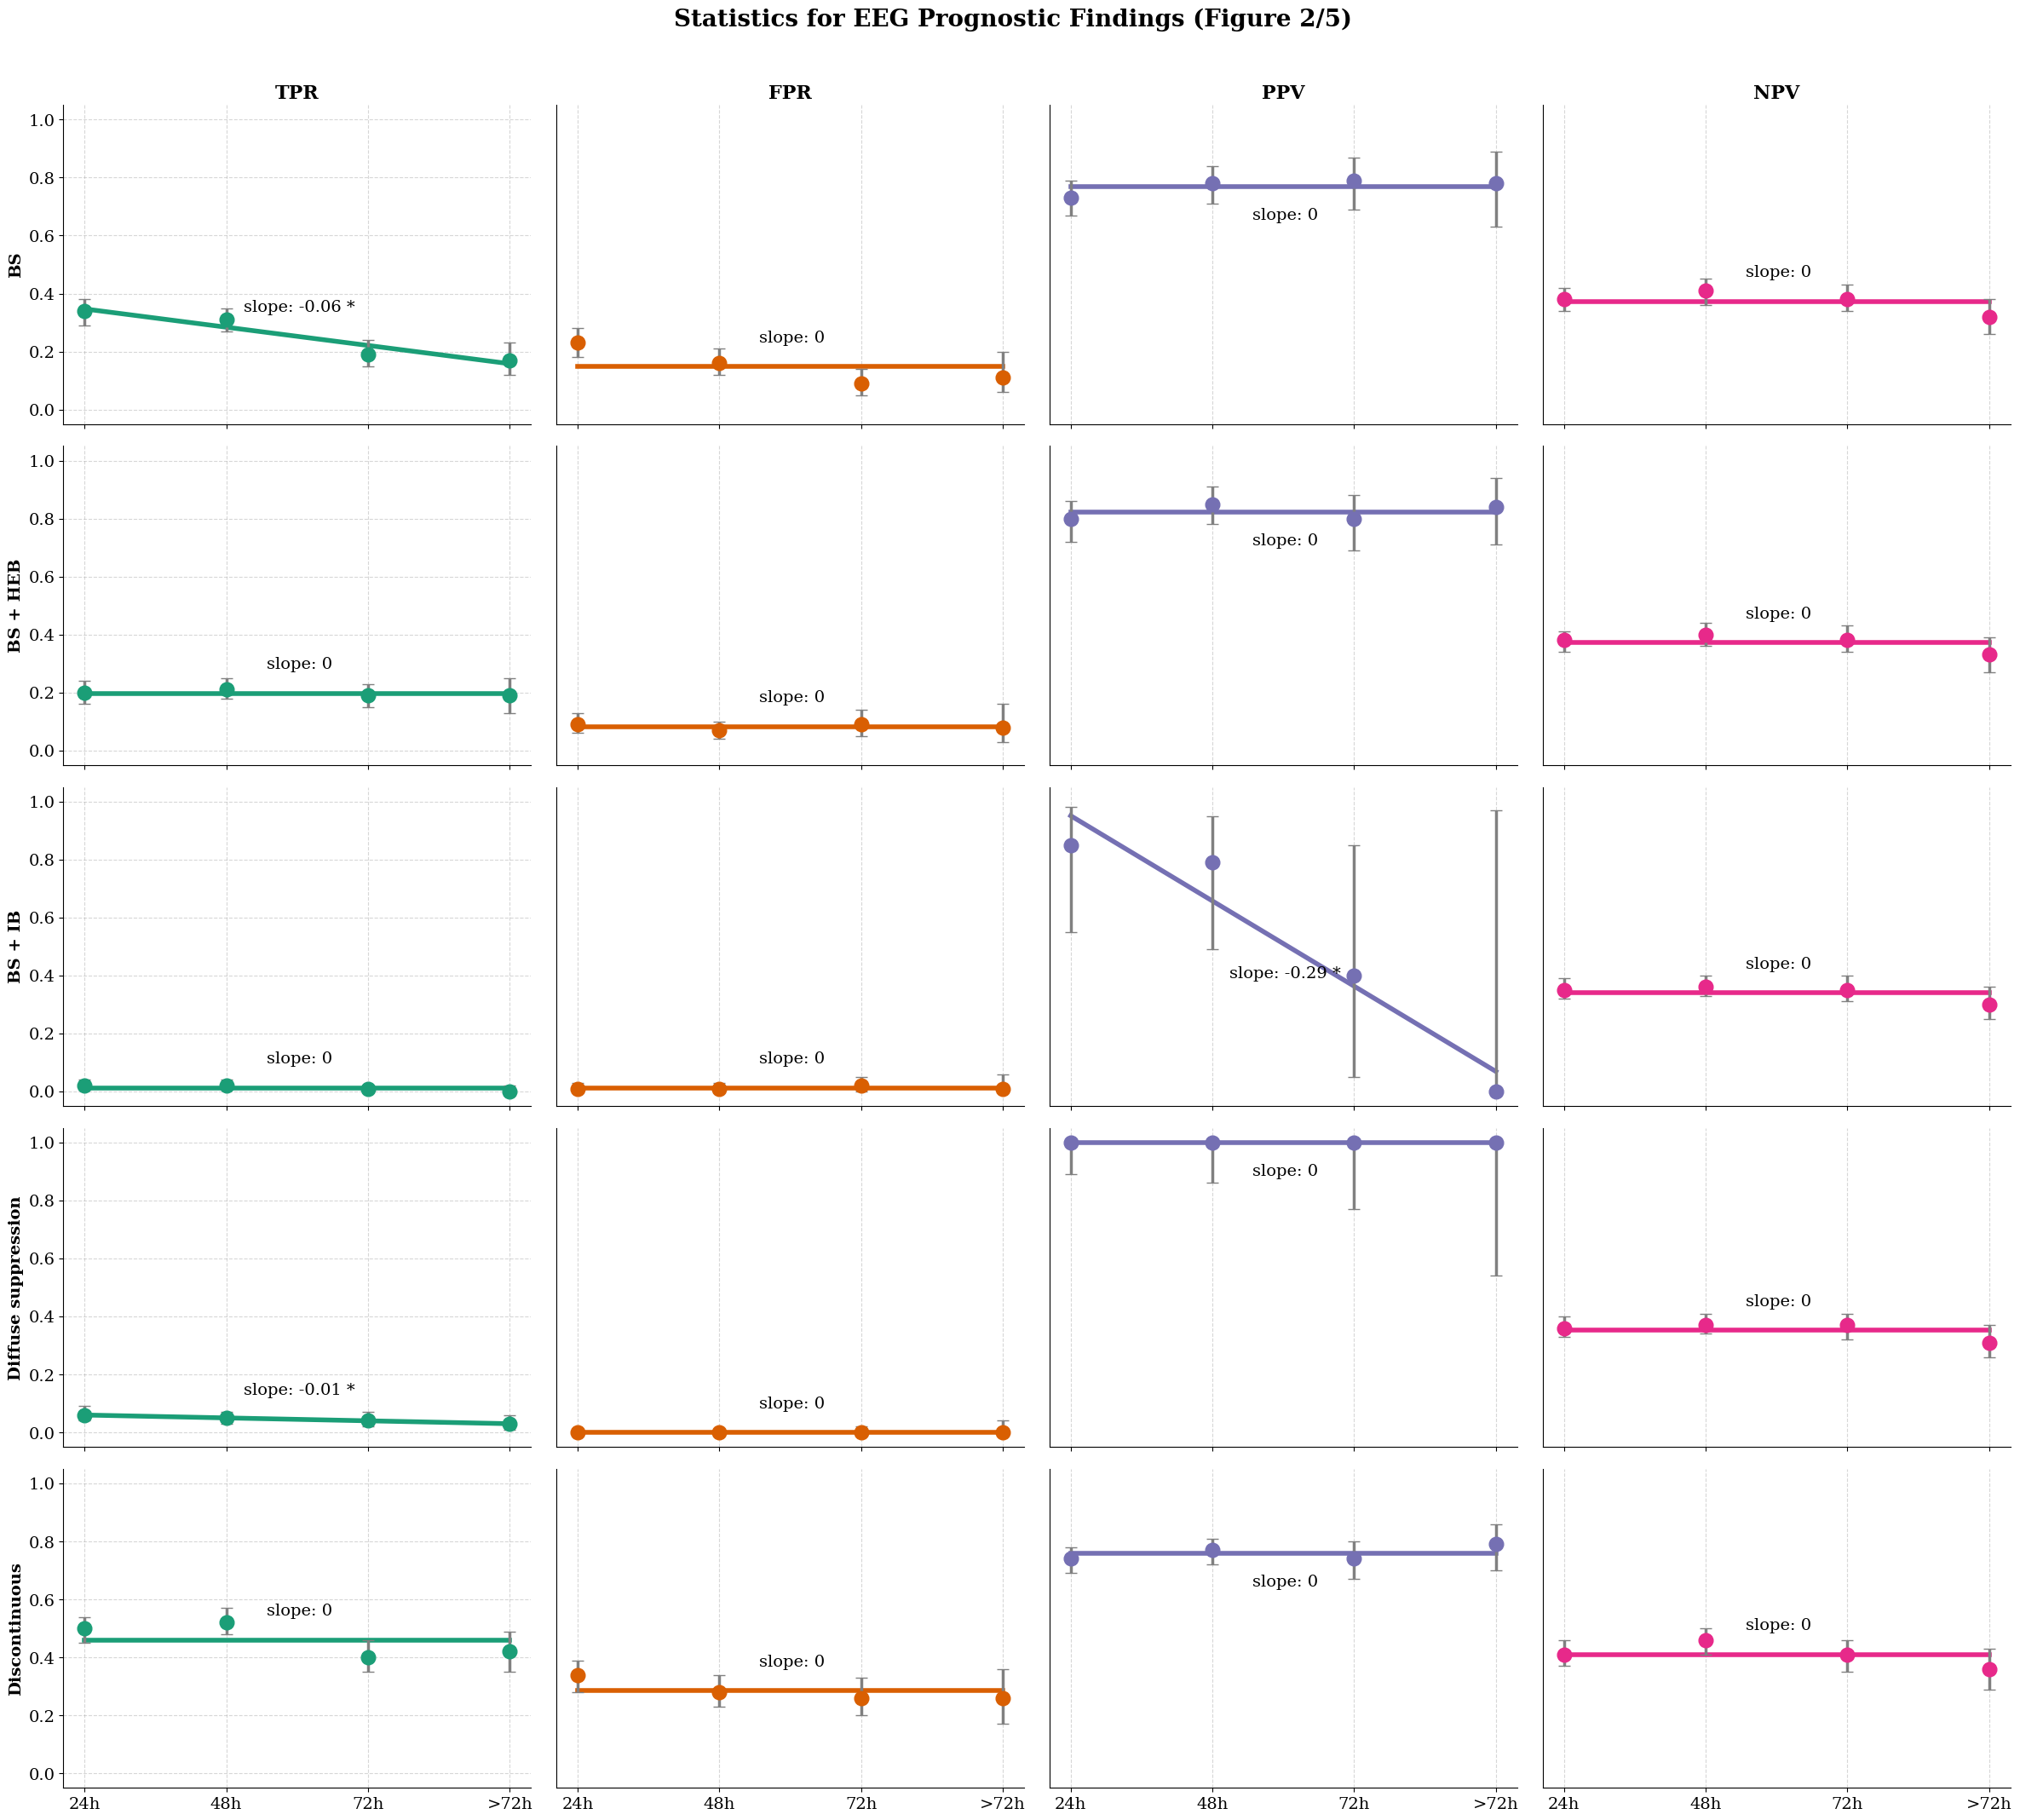

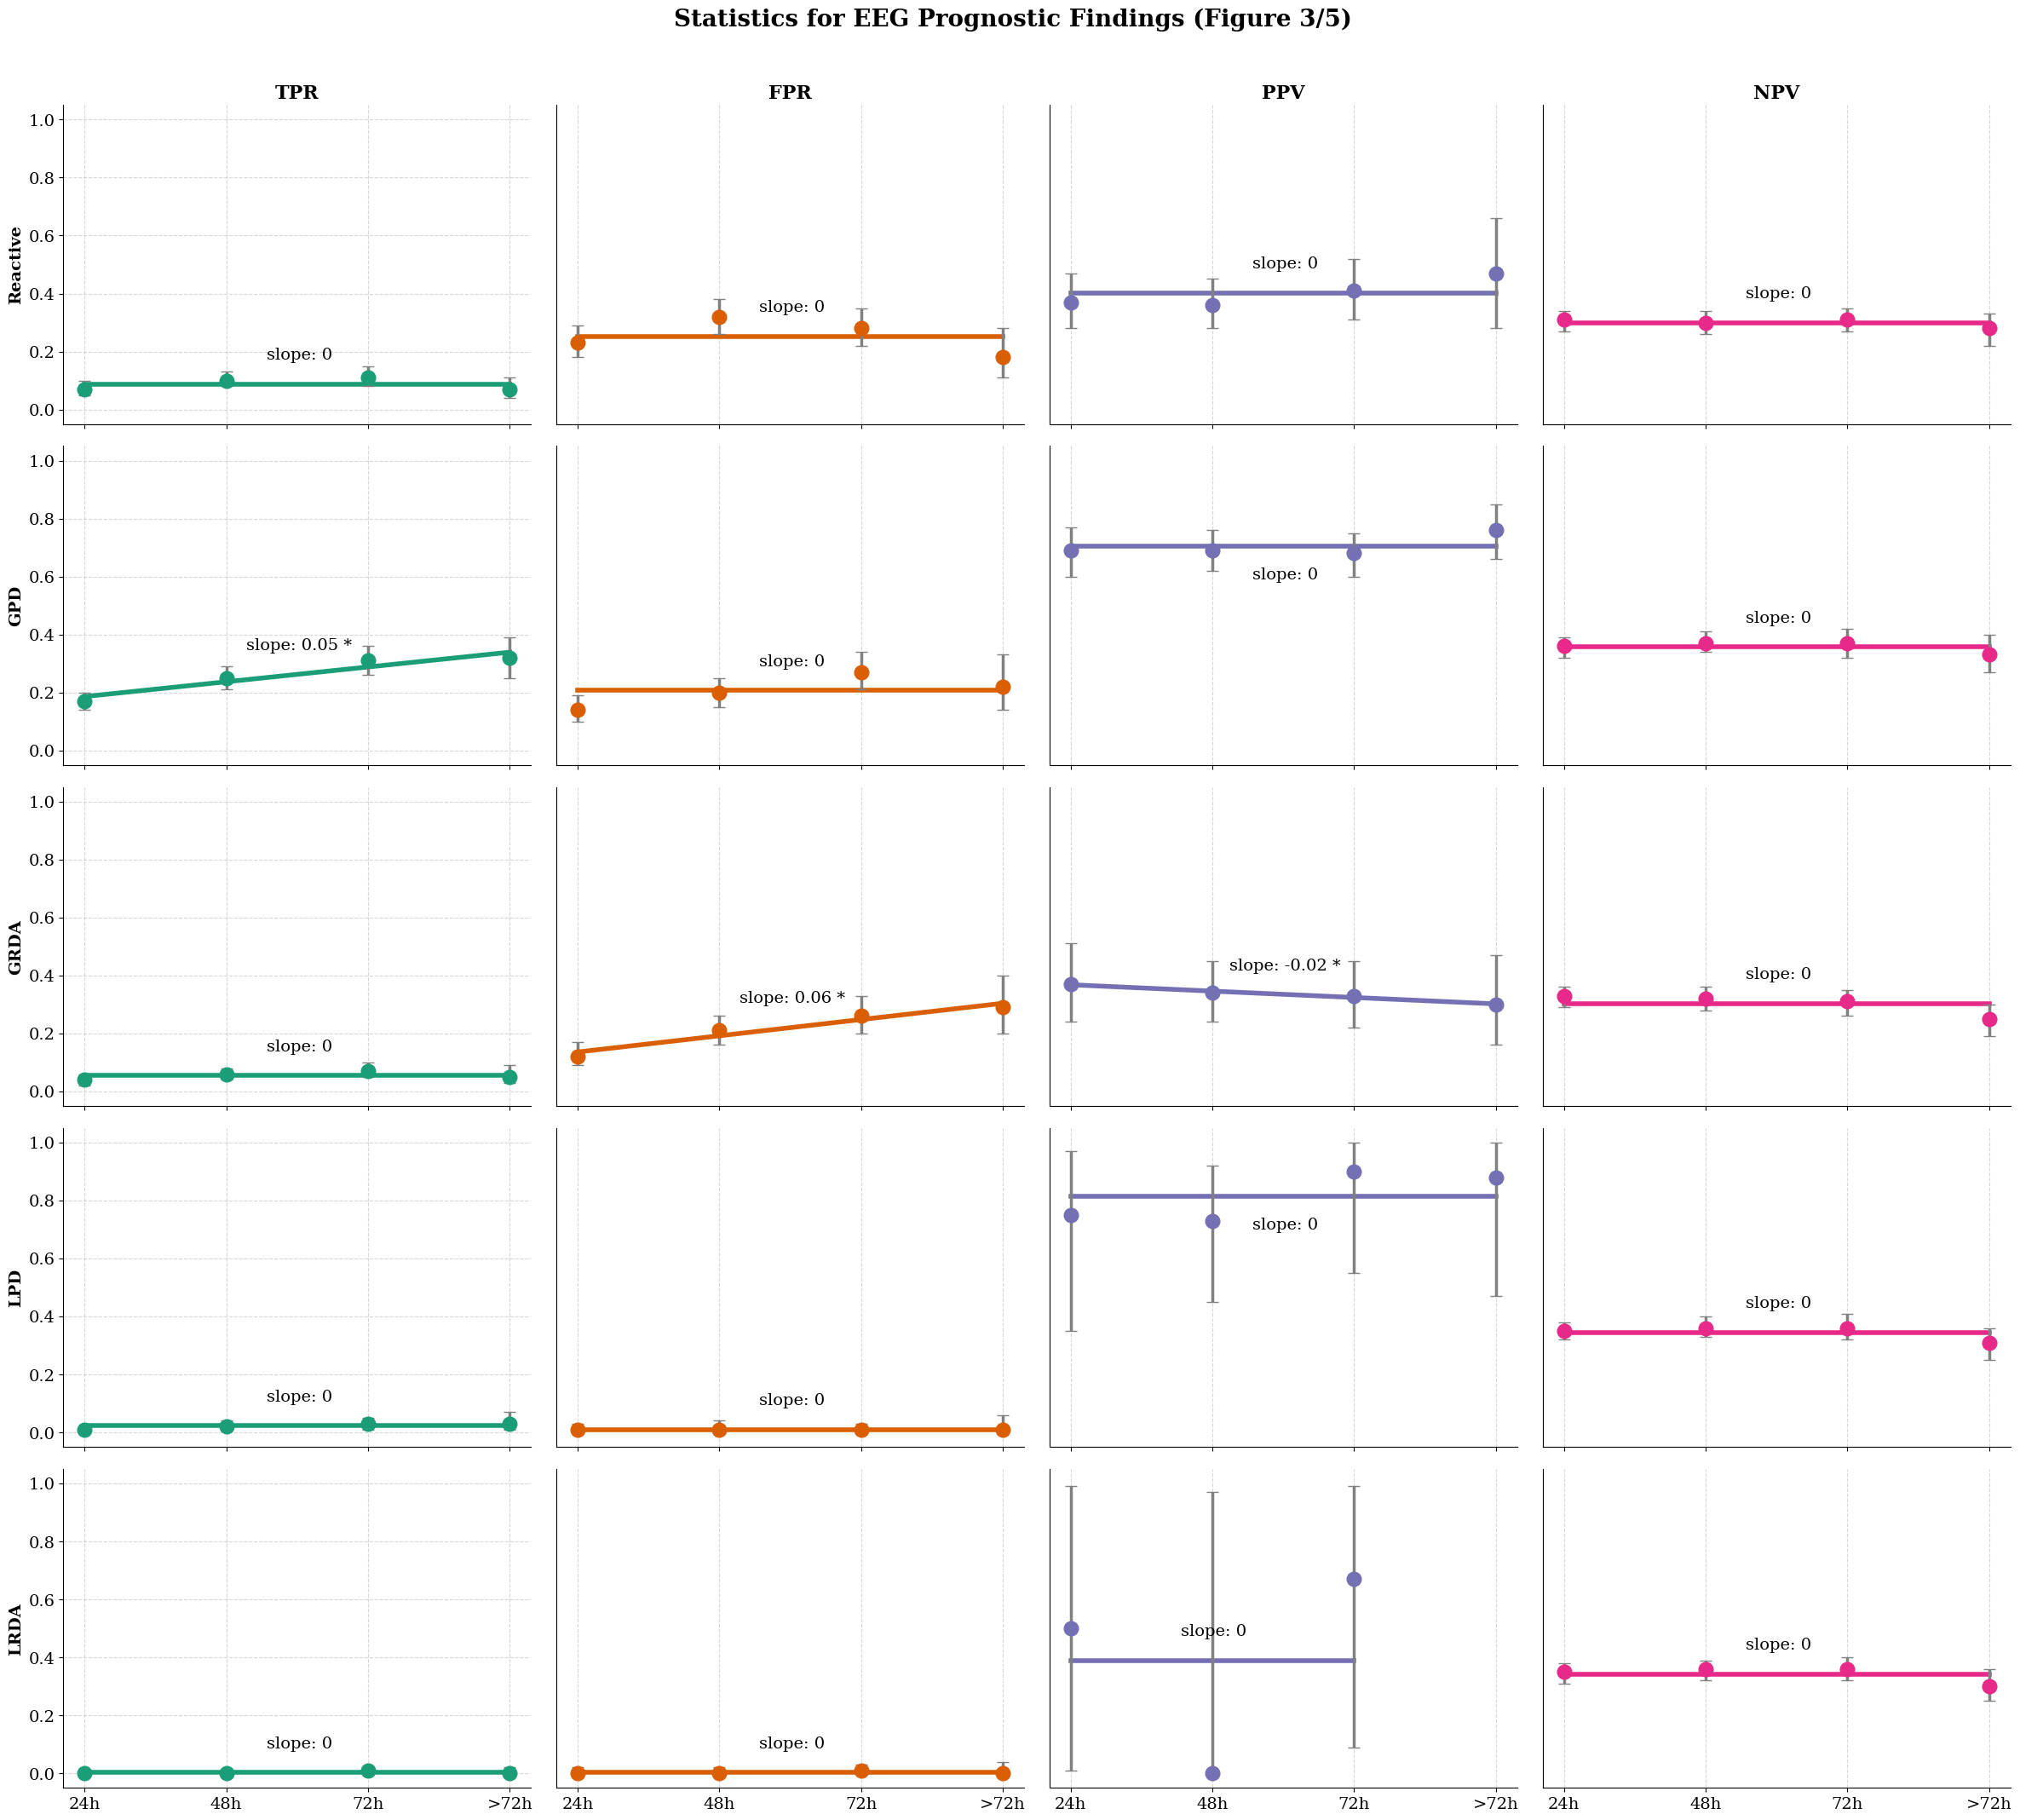

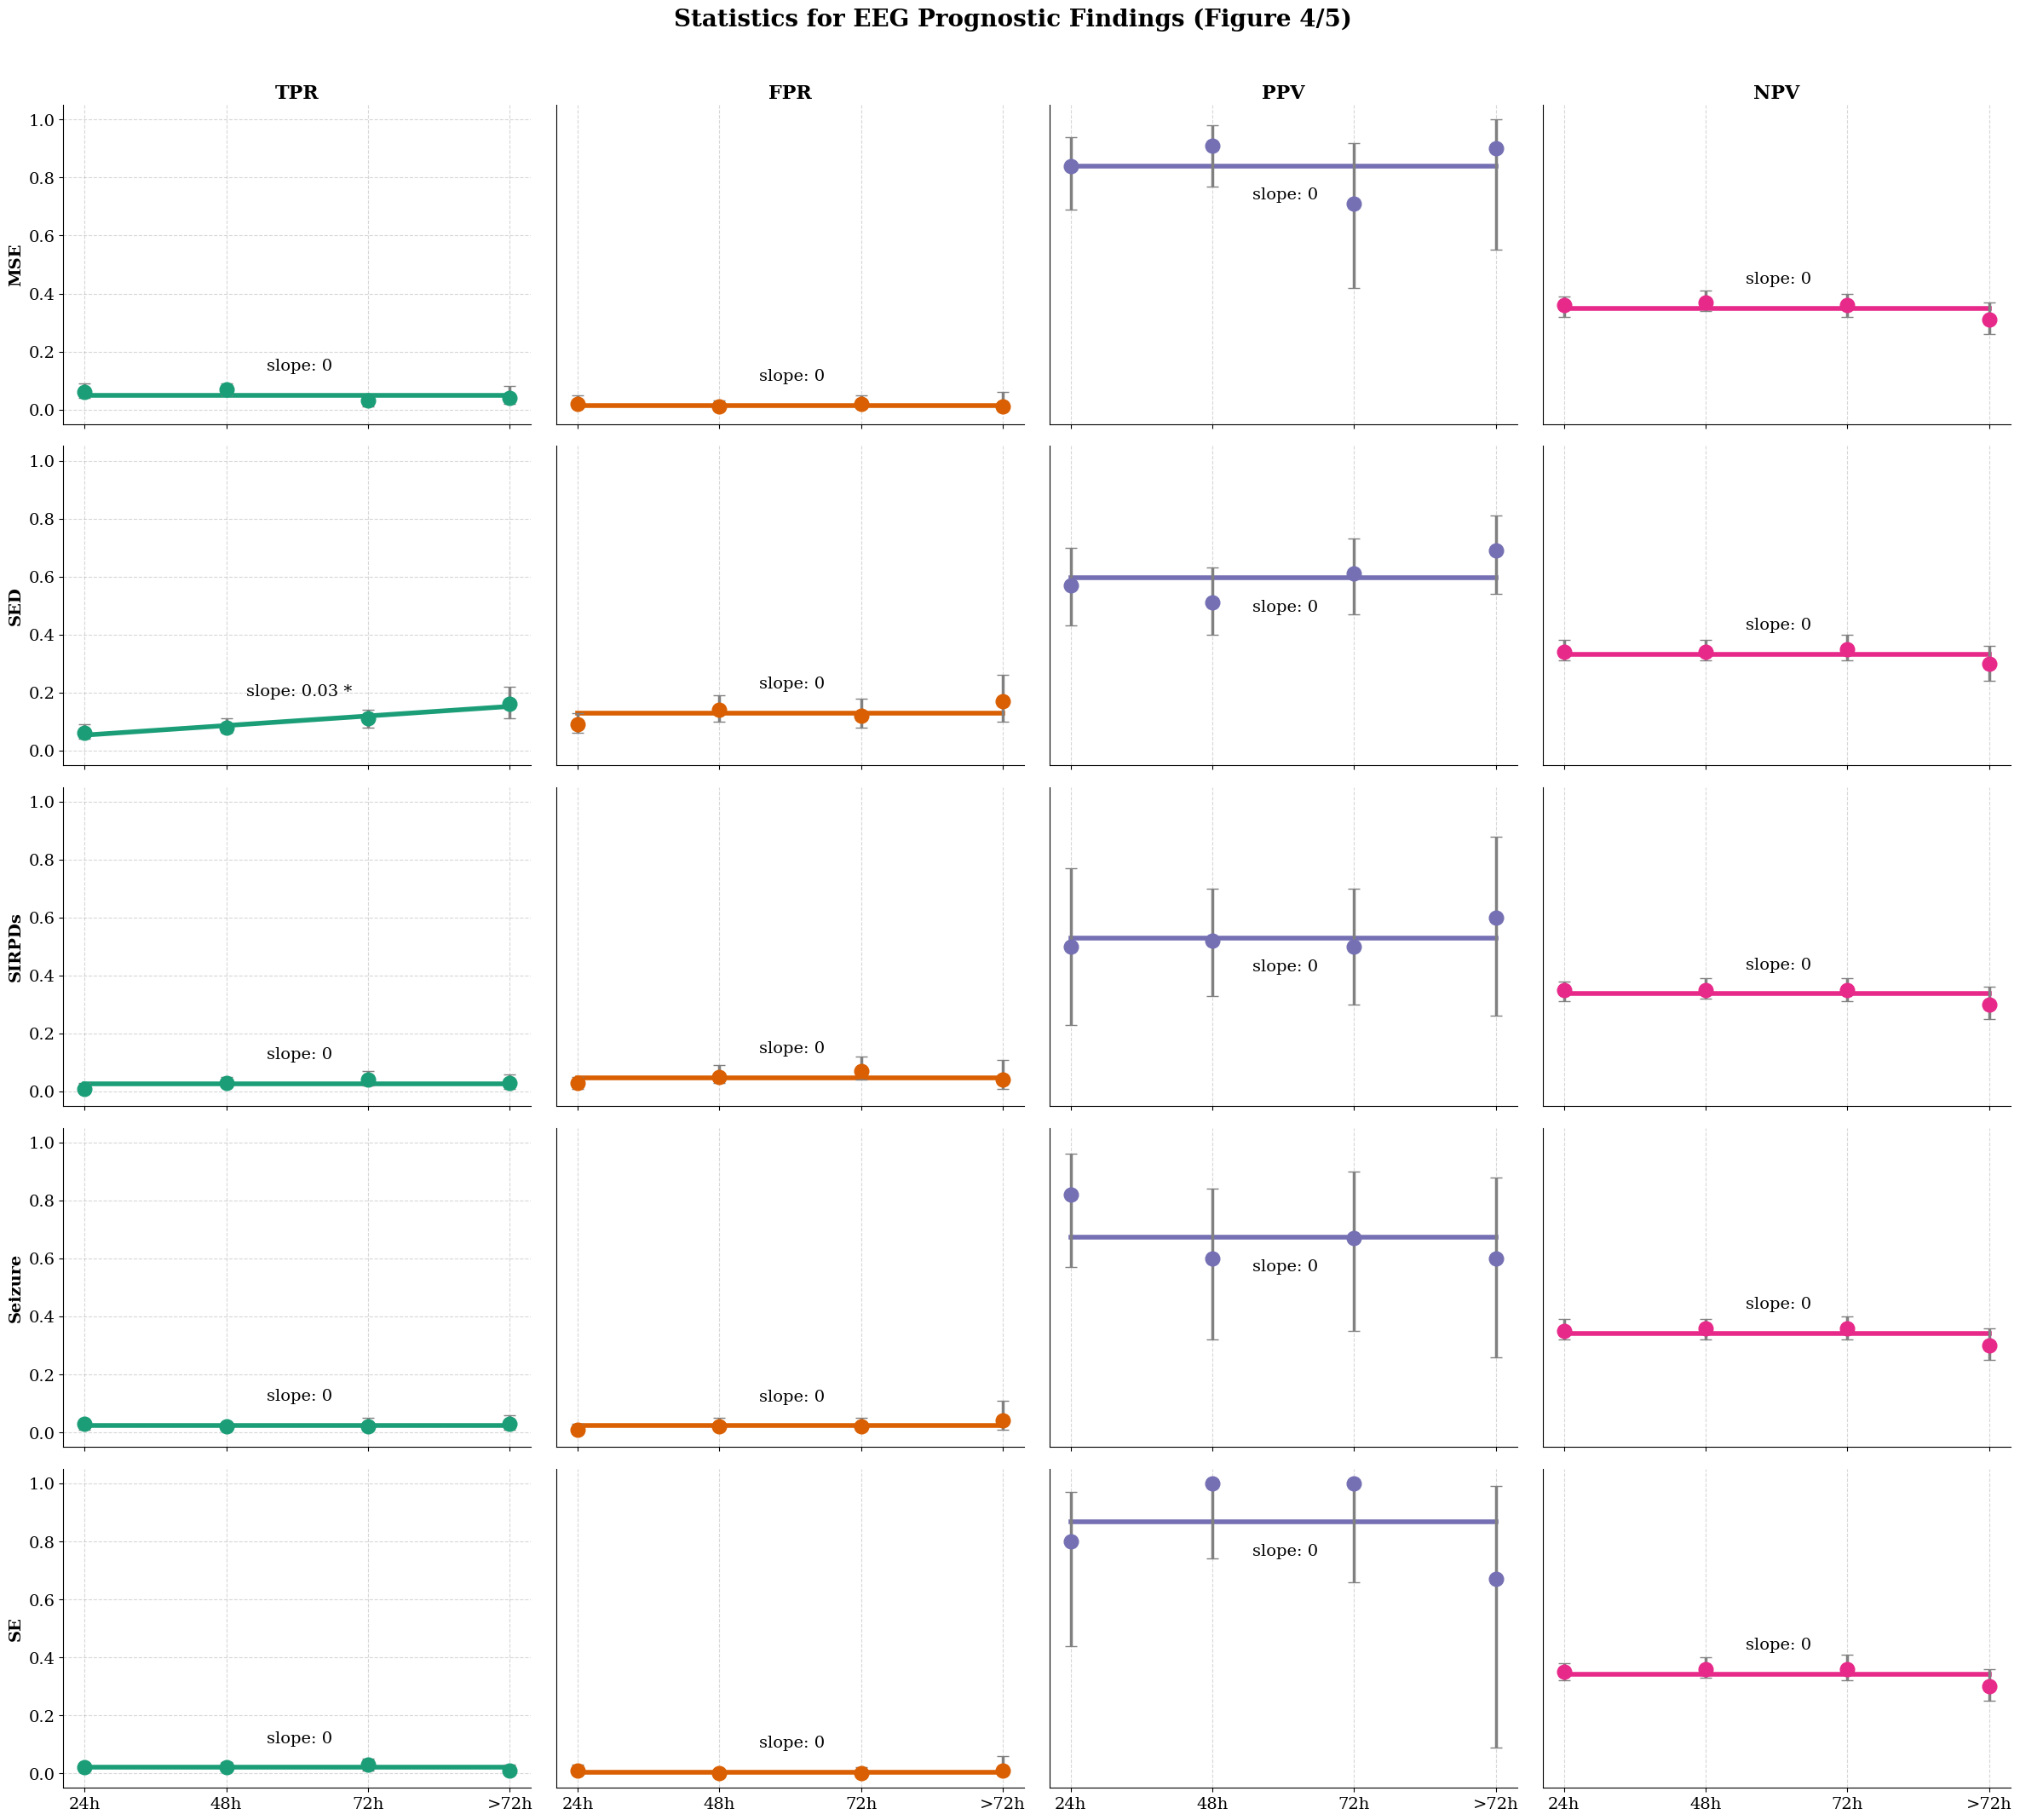

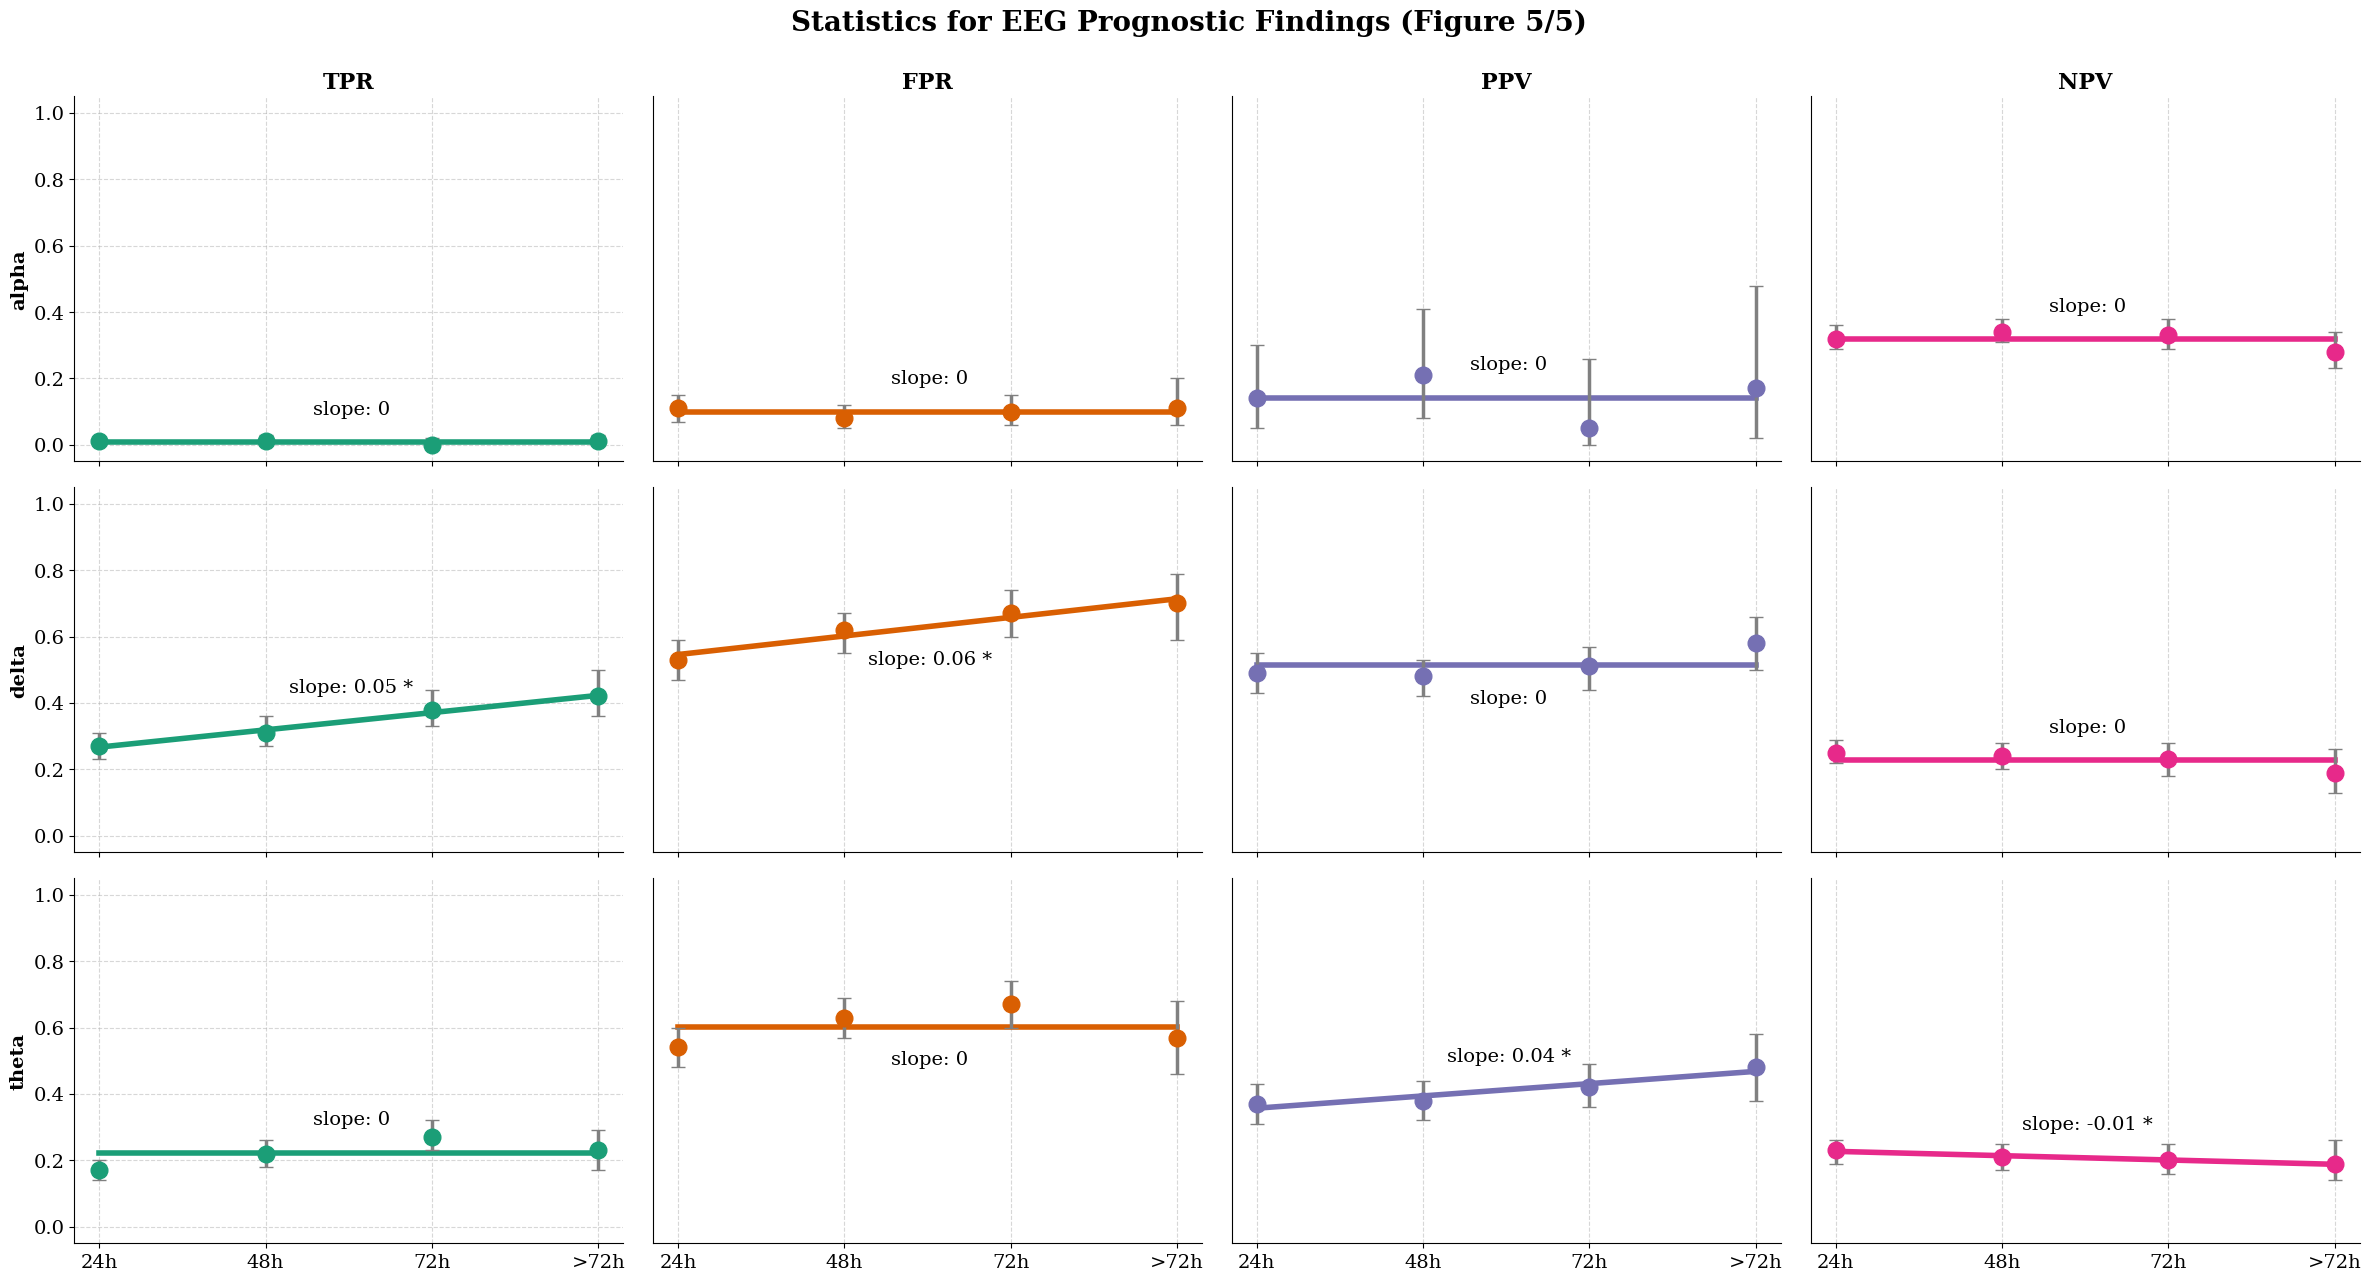

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import linregress

# Load the formatted summary data
df_summary = pd.read_csv('summary_table_with_exact_CI_2025_02_18.csv')

# Define metrics and time periods
metrics = ['TPR', 'FPR', 'PPV', 'NPV']
time_period_order = ['24 hours', '48 hours', '72 hours', 'rest of']

# Sort the DataFrame for consistent plotting
df_summary['Time Period'] = pd.Categorical(df_summary['Time Period'], categories=time_period_order, ordered=True)
df_summary = df_summary.sort_values(['Choice', 'Time Period'])

# Assign numerical values to time periods for regression
time_mapping = {'24 hours': 1, '48 hours': 2, '72 hours': 3, 'rest of': 4}
df_summary['Time_Numeric'] = df_summary['Time Period'].map(time_mapping)

# Get unique EEG findings
unique_choices = sorted(df_summary['Choice'].unique())

# Define number of EEG findings per figure to keep plots manageable
n_per_figure = 5  # Adjust based on preference and screen size
n_figures = int(np.ceil(len(unique_choices) / n_per_figure))

# Define a helper function to sanitize filenames
def sanitize_filename(filename):
    return re.sub(r'[<>:"/\\|?*]', '', filename)

# Define a color palette for metrics (colorblind-friendly)
metric_colors = {
    'TPR': '#1b9e77',  # Green
    'FPR': '#d95f02',  # Orange
    'PPV': '#7570b3',  # Purple
    'NPV': '#e7298a'   # Pink
}

# Update Matplotlib settings for better visuals
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.titlesize': 20,
    'grid.alpha': 0.3
})

# Define a mapping for the updated y-axis labels
y_axis_labels_mapping = {
    'best_background_alpha' :'alpha',
    'best_background_theta':'theta',
    'best_background_delta':'delta',    
    'Discontinuous EEG': 'Discontinuous',
    'EEG reactivity': 'Reactive',
    'Background anytime attenuated 10-20 uV': 'Voltage attenuation',
    'Background anytime suppressed < 10 uV': 'Voltage suppression',
    'Burst suppression': 'BS',
    'Burst suppression with identical bursts': 'BS + IB',
    'Burst suppression with highly epileptiform bursts': 'BS + HEB',
    'Seizure': 'Seizure',
    'Status epilepticus': 'SE',
    'Myoclonic Status epilepticus (time-locked myoclonus and epileptiform discharges)': 'MSE',
    'GPD': 'GPD',
    'LPD': 'LPD',
    'LRDA': 'LRDA',
    'GRDA': 'GRDA',
    'SED': 'SED',
    'SIRPDs': 'SIRPDs',
    'BIRDs': 'BIRDs',
    'Diffuse voltage suppression': 'Diffuse suppression',
    'BIPD': 'BIPD',
    'Absent EEG reactivity': 'Absent reactivity'
}

# Iterate through EEG findings and create plots
for fig_num in range(n_figures):
    # Determine the subset of EEG findings for this figure
    start_idx = fig_num * n_per_figure
    end_idx = start_idx + n_per_figure
    choices_subset = unique_choices[start_idx:end_idx]
    
    # Calculate the number of rows needed (one row per EEG finding)
    n_rows = len(choices_subset)
    n_cols = len(metrics)
    
    # Create a new figure with subplots arranged in rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows), sharex=True)
    
    # If there's only one EEG finding in the subset, make axes a 2D array for consistency
    if n_rows == 1:
        axes = np.array([axes])
    
    # Iterate through each EEG finding in the subset
    for row_idx, choice in enumerate(choices_subset):
        df_choice = df_summary[df_summary['Choice'] == choice].sort_values('Time Period')
        
        # Map the choice to its new y-axis label
        y_label = y_axis_labels_mapping.get(choice, choice)  # Default to the original if not in the mapping
        
        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]

            # Extract metric values and CIs
            x_numeric = df_choice['Time_Numeric'].values.astype(float)
            x_labels = ['24h', '48h', '72h', '>72h']
            y = pd.to_numeric(df_choice[metric], errors='coerce').values
            ci_lower = pd.to_numeric(df_choice[f'{metric}_CI_lower'], errors='coerce').values
            ci_upper = pd.to_numeric(df_choice[f'{metric}_CI_upper'], errors='coerce').values
            
            # Fit a linear regression line to the data
            valid_mask = ~np.isnan(y) & ~np.isnan(x_numeric)  # Filter out NaN values
            slope_text = "slope: 0"
            if np.sum(valid_mask) >= 2:
                slope, intercept, r_value, p_value, std_err = linregress(x_numeric[valid_mask], y[valid_mask])
                significant = p_value < 0.05
                if significant:
                    slope_text = f"slope: {slope:.2f} *"
                    x_smooth = np.linspace(x_numeric[valid_mask].min(), x_numeric[valid_mask].max(), 100)
                    y_smooth = intercept + slope * x_smooth
                else:
                    # Refit with only intercept (mean value of y)
                    intercept = np.mean(y[valid_mask])
                    slope = 0
                    slope_text = "slope: 0"
                    x_smooth = np.linspace(x_numeric[valid_mask].min(), x_numeric[valid_mask].max(), 100)
                    y_smooth = np.full_like(x_smooth, intercept)
                
                # Plot the fitted line
                ax.plot(x_smooth, y_smooth, color=metric_colors.get(metric, 'black'), linestyle='-', linewidth=4.0)
            
            # Plot the original data points with error bars
            ax.errorbar(
                x_numeric, 
                y, 
                yerr=[y - ci_lower, ci_upper - y], 
                fmt='o', 
                color=metric_colors.get(metric, 'black'), 
                ecolor='gray', 
                capsize=5, 
                markersize=12, 
                linewidth=2.5
            )
            
            # Add slope text close to the line with dynamic positioning
            mid_idx = len(x_smooth) // 2  # Get the middle of the x range for positioning the text
            y_mid = y_smooth[mid_idx]  # Midpoint of the line's y-coordinate

            # Set the vertical offset based on the y_mid value
            offset = 0.1 if y_mid < 0.5 else -0.1

            ax.text(
                x_smooth[mid_idx],  # Place text at the x midpoint
                y_mid + offset,     # Adjust y position with the offset
                slope_text,
                fontsize=14,        # Increased font size
                color='black',
                ha='center',
                va='center'
            )

            
            # Customize the subplot
            if row_idx == 0:
                ax.set_title(metric, fontsize=16, fontweight='bold')
            if col_idx == 0:
                ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
            if row_idx == n_rows - 1:
                ax.set_xticks(x_numeric)
                ax.set_xticklabels(x_labels, fontsize=14)
            else:
                ax.set_xticks([])
            
            if col_idx != 0:
                ax.set_yticks([])  # Remove y-axis ticks for all but the first column
            
            ax.set_ylim(-0.05, 1.05)  # Set y-axis limits
            ax.grid(True, linestyle='--', alpha=0.5)
            
            # Remove top and right spines for a cleaner look
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    # Adjust layout and add a main title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(f'Statistics for EEG Prognostic Findings (Figure {fig_num + 1}/{n_figures})', fontsize=20, fontweight='bold')
    
    # Save the figure if desired
    filename = sanitize_filename(f'EEG_Metrics_Figure_{fig_num + 1}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # Display the figure
    plt.show()


In [3]:
import pandas as pd
from scipy.stats import linregress

# Load the summary table
df_summary = pd.read_csv('summary_table_with_exact_CI_2025_02_18.csv')

# Apply the same choice mapping as in ResultsTable.csv
choice_mapping = {
    "best_background_alpha":"alpha",
    "best_background_theta":"theta",
    "best_background_delta":"delta",    
    "Discontinuous EEG": "Discontinuous",
    "EEG reactivity": "Reactivity",
    "Background anytime attenuated 10-20 uV": "Attenuation (10-20 uV)",
    "Background anytime suppressed < 10 uV": "Suppression (<10 uV)",
    "Burst suppression": "Burst suppression",
    "Burst suppression with identical bursts": "Burst suppression + IB",
    "Burst suppression with highly epileptiform bursts": "Burst suppression + HEB",
    "Seizure": "Seizure",
    "Status epilepticus": "Status epilepticus",
    "Myoclonic Status epilepticus (time-locked myoclonus and epileptiform discharges)": "Myoclonic Status epilepticus",
    "GPD": "GPD",
    "LPD": "LPD",
    "LRDA": "LRDA",
    "GRDA": "GRDA",
    "SED": "SED",
    "SIRPDs": "SIRPDs",
    "BIRDs": "BIRDs",
    "Diffuse voltage suppression": "Extreme voltage suppression",
    "BIPD": "BIPD",
    "Absent EEG reactivity": "Absent reactivity"
}
df_summary['Choice'] = df_summary['Choice'].map(choice_mapping)

# Create the Time_Numeric column for regression
time_mapping = {'24 hours': 1, '48 hours': 2, '72 hours': 3, 'rest of': 4}
df_summary['Time_Numeric'] = df_summary['Time Period'].map(time_mapping)

# Initialize a list to store slope data
slope_results = []

# Metrics to analyze
metrics = ['TPR', 'FPR', 'PPV', 'NPV']

# Iterate through EEG findings and metrics
for choice in sorted(df_summary['Choice'].unique()):  # Ensure the findings are processed in sorted order
    df_choice = df_summary[df_summary['Choice'] == choice].sort_values('Time_Numeric')
    for metric in metrics:
        # Extract metric values
        x_numeric = df_choice['Time_Numeric'].values.astype(float)
        y = pd.to_numeric(df_choice[metric], errors='coerce').values
        
        # Fit a linear regression line to the data
        valid_mask = ~np.isnan(y) & ~np.isnan(x_numeric)  # Filter out NaN values
        if np.sum(valid_mask) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(x_numeric[valid_mask], y[valid_mask])
            # Save results for this choice and metric
            slope_results.append({
                'EEG Finding': choice,
                'Metric': metric,
                'Slope': round(slope, 4),
                'P-value': round(p_value, 4),
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        else:
            # Handle cases where linear regression could not be applied
            slope_results.append({
                'EEG Finding': choice,
                'Metric': metric,
                'Slope': 'N/A',
                'P-value': 'N/A',
                'Significant': 'N/A'
            })

# Convert results to a DataFrame
df_slopes = pd.DataFrame(slope_results)

# Save the results to a CSV file
output_filename = "Slopes.csv"
df_slopes.to_csv(output_filename, index=False)

print(f"Slope results with matching labels have been saved to {output_filename}.")


Slope results with matching labels have been saved to Slopes.csv.


In [4]:
import pandas as pd
import numpy as np

# Load the summary table
df_summary = pd.read_csv('summary_table_with_exact_CI_2025_02_18.csv')

# Define a function to format the "Died" and "Survived" columns
def format_count_and_percentage(row, count_col, percentage_col):
    count = row[count_col]
    percentage = row[percentage_col]
    return f"{count} ({percentage}%)"

# Define a function to format rates with confidence intervals
def format_rate_with_ci(row, rate_col, lower_ci_col, upper_ci_col):
    rate = row[rate_col]
    lower_ci = row[lower_ci_col]
    upper_ci = row[upper_ci_col]
    return f"{rate} [{lower_ci}, {upper_ci}]"

# Create a mapping of old names to new names
choice_mapping = {
    "best_background_alpha":"alpha",
    "best_background_theta":"theta",
    "best_background_delta":"delta",
    "Discontinuous EEG": "Discontinuous",
    "EEG reactivity": "Reactivity",
    "Background anytime attenuated 10-20 uV": "Attenuation (10-20 uV)",
    "Background anytime suppressed < 10 uV": "Suppression (<10 uV)",
    "Burst suppression": "Burst suppression",
    "Burst suppression with identical bursts": "Burst suppression + IB",
    "Burst suppression with highly epileptiform bursts": "Burst suppression + HEB",
    "Seizure": "Seizure",
    "Status epilepticus": "Status epilepticus",
    "Myoclonic Status epilepticus (time-locked myoclonus and epileptiform discharges)": "Myoclonic Status epilepticus",
    "GPD": "GPD",
    "LPD": "LPD",
    "LRDA": "LRDA",
    "GRDA": "GRDA",
    "SED": "SED",
    "SIRPDs": "SIRPDs",
    "BIRDs": "BIRDs",
    "Diffuse voltage suppression": "Extreme voltage suppression",
    "BIPD": "BIPD",
    "Absent EEG reactivity": "Absent reactivity"
}

# Apply the mapping to the "Choice" column
df_summary['Choice'] = df_summary['Choice'].map(choice_mapping)

# Rename and reorder the "Time Period" column
time_period_mapping = {
    "24 hours": "24h",
    "48 hours": "48h",
    "72 hours": "72h",
    "rest of": ">72h"
}
df_summary['Time Period'] = df_summary['Time Period'].map(time_period_mapping)

time_period_order = ["24h", "48h", "72h", ">72h"]

# Format the desired columns
df_summary['Died'] = df_summary.apply(
    lambda row: format_count_and_percentage(row, 'Died', 'Died_Percentage'), axis=1
)
df_summary['Survived'] = df_summary.apply(
    lambda row: format_count_and_percentage(row, 'Survived', 'Survived_Percentage'), axis=1
)

df_summary['TPR'] = df_summary.apply(
    lambda row: format_rate_with_ci(row, 'TPR', 'TPR_CI_lower', 'TPR_CI_upper'), axis=1
)
df_summary['FPR'] = df_summary.apply(
    lambda row: format_rate_with_ci(row, 'FPR', 'FPR_CI_lower', 'FPR_CI_upper'), axis=1
)
df_summary['PPV'] = df_summary.apply(
    lambda row: format_rate_with_ci(row, 'PPV', 'PPV_CI_lower', 'PPV_CI_upper'), axis=1
)
df_summary['NPV'] = df_summary.apply(
    lambda row: format_rate_with_ci(row, 'NPV', 'NPV_CI_lower', 'NPV_CI_upper'), axis=1
)

# Define the desired order of findings
desired_order = [
    "alpha", "theta", "delta", "Attenuation (10-20 uV)", "Suppression (<10 uV)", "Discontinuous",
    "Burst suppression", "Burst suppression + IB", "Burst suppression + HEB",
    "Extreme voltage suppression", "Reactivity", "Absent reactivity",
    "Seizure", "Status epilepticus", "Myoclonic Status epilepticus",
    "GPD", "LPD", "LRDA", "GRDA", "SED", "SIRPDs", "BIRDs", "BIPD"
]

# Reorder the rows: Group by "Choice" and sort "Time Period" within each group
df_summary['ChoiceOrder'] = df_summary['Choice'].apply(lambda x: desired_order.index(x))
df_summary['TimePeriodOrder'] = df_summary['Time Period'].apply(lambda x: time_period_order.index(x))

# Sort by Choice first, then Time Period within each Choice
df_summary = df_summary.sort_values(by=['ChoiceOrder', 'TimePeriodOrder']).drop(columns=['ChoiceOrder', 'TimePeriodOrder'])

# Select and reorder the desired columns
columns_to_keep = [
    'Choice', 'Time Period', 'Total', 'Died', 'Survived', 
    'TP', 'FP', 'FN', 'TN', 'TPR', 'FPR', 'PPV', 'NPV'
]
df_results_table = df_summary[columns_to_keep]

# Save the formatted table to a new CSV file
df_results_table.to_csv('ResultsTable.csv', index=False)

print("Formatted results table saved as 'ResultsTable.csv'")


Formatted results table saved as 'ResultsTable.csv'


In [5]:
import pandas as pd

# File paths
results_table_path = 'ResultsTable.csv'
output_path = 'Results_For_EEG_Report.csv'

# Read the input file
results_table = pd.read_csv(results_table_path)

# Ensure the column names match and are not case-sensitive
results_table.columns = results_table.columns.str.strip()

# Filter the data to only include rows for 72 hours
filtered_results = results_table[results_table['Time Period'] == '72h']

# Calculate the total number of individuals with each finding (N = TP + FP)
filtered_results['Total'] = filtered_results['TP'] + filtered_results['FP']

# Create the "Died" column: number of individuals with a poor outcome (TP)
filtered_results['Died'] = filtered_results['TP']

# Create the "Survived" column: number of survivors (FP)
filtered_results['Survived'] = filtered_results['FP']

# Rearrange columns to include "Total", "Died", "Survived", and then "PPO"
columns_to_keep = ['Choice', 'Total', 'Died', 'Survived', 'PPV']
final_results = filtered_results[columns_to_keep]

# Sort the results in ascending order of PPV
# Extract the numerical PPV value from the confidence interval string for sorting
def extract_ppv_value(ppv_string):
    try:
        return float(ppv_string.split()[0])  # Extracts the first numeric value
    except (ValueError, AttributeError):
        return float('inf')  # If invalid, place it at the end

final_results['PPV_numeric'] = final_results['PPV'].apply(extract_ppv_value)
final_results = final_results.sort_values(by='PPV_numeric', ascending=True).drop(columns=['PPV_numeric'])

# Rename the columns as requested
final_results.rename(columns={
    'Choice': 'Pattern',
    'PPV': 'PPO'
}, inplace=True)

# Save the final results to the output file
final_results.to_csv(output_path, index=False)

print(f"Filtered, formatted, and sorted results saved to {output_path}")


Filtered, formatted, and sorted results saved to Results_For_EEG_Report.csv


/var/folders/lg/qf0_x9r91qjg9ndqydrbphzw0000gq/T/ipykernel_94623/478029175.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['Total'] = filtered_results['TP'] + filtered_results['FP']
/var/folders/lg/qf0_x9r91qjg9ndqydrbphzw0000gq/T/ipykernel_94623/478029175.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['Died'] = filtered_results['TP']
/var/folders/lg/qf0_x9r91qjg9ndqydrbphzw0000gq/T/ipykernel_94623/478029175.py:23: SettingWithCopyWarning: 
A value is trying to be

In [6]:
results_table

,Choice,Time Period,Total,Died,Survived,TP,FP,FN,TN,TPR,FPR,PPV,NPV
0,alpha,24h,796,519 (65.2%),277 (34.8%),5,30,514,247,"0.01 [0.0, 0.02]","0.11 [0.07, 0.15]","0.14 [0.05, 0.3]","0.32 [0.29, 0.36]"
1,alpha,48h,762,489 (64.17%),273 (35.83%),6,22,483,251,"0.01 [0.0, 0.03]","0.08 [0.05, 0.12]","0.21 [0.08, 0.41]","0.34 [0.31, 0.38]"
2,alpha,72h,524,337 (64.31%),187 (35.69%),1,18,336,169,"0.0 [0.0, 0.02]","0.1 [0.06, 0.15]","0.05 [0.0, 0.26]","0.33 [0.29, 0.38]"
3,alpha,>72h,294,205 (69.73%),89 (30.27%),2,10,203,79,"0.01 [0.0, 0.03]","0.11 [0.06, 0.2]","0.17 [0.02, 0.48]","0.28 [0.23, 0.34]"
4,theta,24h,796,519 (65.2%),277 (34.8%),87,150,432,127,"0.17 [0.14, 0.2]","0.54 [0.48, 0.6]","0.37 [0.31, 0.43]","0.23 [0.19, 0.26]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,BIRDs,>72h,294,205 (69.73%),89 (30.27%),0,0,205,89,"0.0 [0.0, 0.02]","0.0 [0.0, 0.04]","nan [nan, nan]","0.3 [0.25, 0.36]"
88,BIPD,24h,796,519 (65.2%),277 (34.8%),2,0,517,277,"0.0 [0.0, 0.01]","0.0 [0.0, 0.01]","1.0 [0.16, 1.0]","0.35 [0.32, 0.38]"
89,BIPD,48h,762,489 (64.17%),273 (35.83%),5,1,484,272,"0.01 [0.0, 0.02]","0.0 [0.0, 0.02]","0.83 [0.36, 1.0]","0.36 [0.33, 0.4]"
90,BIPD,72h,524,337 (64.31%),187 (35.69%),7,1,330,186,"0.02 [0.01, 0.04]","0.01 [0.0, 0.03]","0.88 [0.47, 1.0]","0.36 [0.32, 0.4]"
